In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import random

from IPython import display

import pickle

np.set_printoptions(precision=3, suppress=True)

Using TensorFlow backend.


In [2]:
COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
                "dim5", "dim6", "dim7", "dim8", 
                "dim9", "dim10", "label"]
LABEL_NAME = "label"
INPUT_NAMES = list(COLUMN_NAMES)
INPUT_NAMES.remove(LABEL_NAME)
trajectory_list = pickle.load(open("N-Dim_Doublewell/trajectory_list.p", "rb"))
trajectory_label_list = pickle.load(open("N-Dim_Doublewell/trajectory_label_list.p", "rb"))
BATCH_SIZE = 64
#SHUFFLE_BUFFER_SIZE = 1000000
CORES_USED = 3

# sets a random seed for reproducibility of the shuffling process
SEED = 5



In [3]:
# additional section can be used for generation of present/future pairs

OFFSET = 5
def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return present_trajectory_list, future_trajectory_list

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_progress_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            snapshot_label_list.append(trajectory_label)
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if trajectory_label == 0.0 or trajectory_label == 1.0:
                snapshot_progress_label_list.append(trajectory_label)
            else:
                if future == True:
                    snapshot_progress_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                else:
                    snapshot_progress_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_progress_label_list)



In [4]:
snapshot_list, snapshot_label_list, snapshot_progress_label_list = get_snapshot_and_label_list(trajectory_list, trajectory_label_list)

#present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, OFFSET)

#present_snapshot_list, present_snapshot_label_list, present_snapshot_progress_label_list = get_snapshot_and_label_list(
#    present_trajectory_list, trajectory_label_list, OFFSET)
#future_snapshot_list, future_snapshot_label_list, future_snapshot_progress_label_list = get_snapshot_and_label_list(
#    future_trajectory_list, trajectory_label_list, OFFSET, future = True)

# Sets a split size for train and test data set
DATASET_SIZE = len(snapshot_label_list)
TRAIN_SIZE = int(DATASET_SIZE * 0.7)

In [5]:

# generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": snapshot_list},
                                        {"label":snapshot_label_list, 
                                         "reconstruction":snapshot_list})).shuffle(DATASET_SIZE)
train_ds = ds.take(TRAIN_SIZE).batch(BATCH_SIZE)
test_ds = ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)

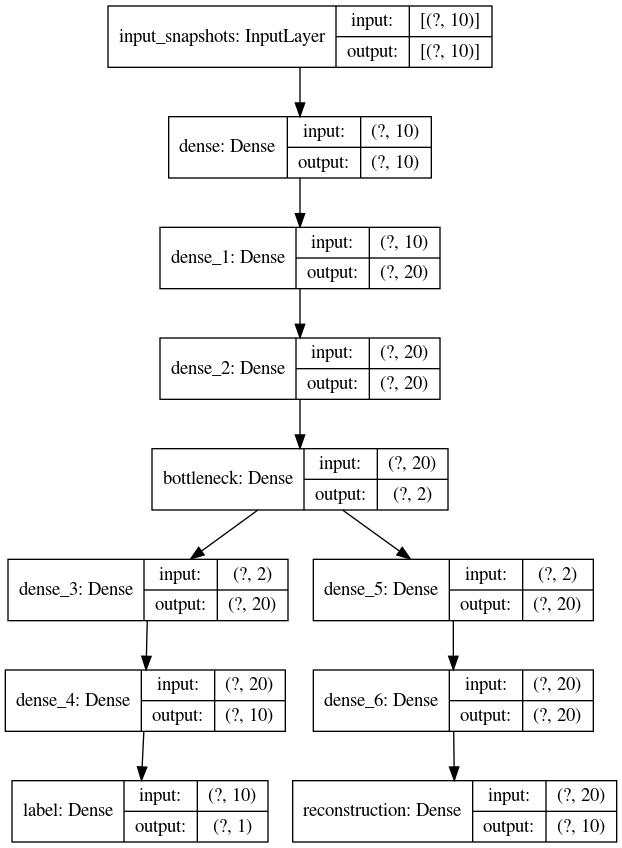

In [6]:
import pydot

input_snapshots = keras.Input(shape=(len(INPUT_NAMES),),name="input_snapshots")
x = keras.layers.Dense(len(INPUT_NAMES), activation= 'tanh')(input_snapshots)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x = keras.layers.Dense(2, activation='tanh', name='bottleneck')(x)

x1 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x1 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh')(x1)
output_1 = keras.layers.Dense(1, activation='tanh',name="label")(x1)

x2 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x2 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x2)
output_2 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh',name="reconstruction")(x2)



model = keras.Model(inputs=input_snapshots,outputs=[output_1,output_2])
model_layout = keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)
display.display(model_layout)


In [7]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'label':keras.losses.MeanAbsoluteError(),
                      'reconstruction': keras.losses.MeanAbsoluteError()},
              loss_weights=[1., 0.2])

In [8]:
model.fit(train_ds,
          epochs=10)


Train for 2522 steps
Epoch 1/10
2522/2522 [==============================] - 6s 2ms/step - loss: 0.1410 - label_loss: 0.0570 - reconstruction_loss: 0.4204
Epoch 2/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1243 - label_loss: 0.0417 - reconstruction_loss: 0.4130
Epoch 3/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1221 - label_loss: 0.0409 - reconstruction_loss: 0.4057
Epoch 4/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1191 - label_loss: 0.0399 - reconstruction_loss: 0.3961
Epoch 5/10
2522/2522 [==============================] - 4s 2ms/step - loss: 0.1173 - label_loss: 0.0391 - reconstruction_loss: 0.3909
Epoch 6/10
2522/2522 [==============================] - 4s 2ms/step - loss: 0.1164 - label_loss: 0.0388 - reconstruction_loss: 0.3880
Epoch 7/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1152 - label_loss: 0.0381 - reconstruction_loss: 0.3859
Epoch 8/10
2522/2522 [===================

In [9]:
model.evaluate(test_ds, verbose=1, steps = 1000)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.1116 - label_loss: 0.0351 - reconstruction_loss: 0.3827


[0.11160640798509121, 0.035058215, 0.38274089]

In [10]:
#print(model.predict([[0, -1] + [0 for i in range(8)]]))
#print(model.predict(snapshot_list[:1000])[1][0][1])
def map_generated_labels(model, x_list, y_list, additional_dim_nr, additional_dim_val, x_var_pos, y_var_pos):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_row.append(model.predict([[x if x_var_pos == pos_nr else y if y_var_pos == pos_nr else additional_dim_val for pos_nr in range(2 + additional_dim_nr)]])[0][0][0])
        label_map.append(label_current_row)
        #print(label_current_row)
    return np.array(label_map)

In [11]:
import math
def map_given_labels(snapshot_list, snapshot_label_list, x_list, y_list):
    x_nr = len(x_list)
    y_nr = len(y_list)
    # determines the lenght of half a step on the grid to see which grid point the snapshot belongs to
    x_half_step = (max(x_list) - min(x_list)) / (2 * float(x_nr-1))
    y_half_step = (max(y_list) - min(y_list)) / (2 * float(y_nr-1))
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_entry = []
            for snapshot_nr in range(len(snapshot_list)):
                x_snap = snapshot_list[snapshot_nr][x_var_pos]
                y_snap = snapshot_list[snapshot_nr][y_var_pos]
                # check whether current snapshot is close to current x and y, if it is, add label to current entry
                if abs(x_snap - x) <= x_half_step and abs(y_snap - y) <= y_half_step:
                    label_current_entry.append(snapshot_label_list[snapshot_nr])
            # after all snapshots are done for this position, take the mean of the current entry
            # and append it to current row
            if len(label_current_entry) > 0:
                label_current_row.append(np.mean(label_current_entry))
            else:
                label_current_row.append(float('NaN'))
        label_map.append(label_current_row)
    return label_map


In [12]:
def map_given_labels_efficiently(snapshot_list, snapshot_label_list, x_list, y_list, x_var_pos, y_var_pos):
    x_nr = len(x_list)
    y_nr = len(y_list)
    min_x = min(x_list)
    max_x = max(x_list)
    min_y = min(y_list)
    max_y = max(y_list)
    # generate a list of lists of lists to store all labels in
    label_map = [[[] for y in y_list] for x in x_list]
    # sort the labels of each snapshot to the corresponding "positions" in the grid (by sorting them in the list)
    for snapshot_nr in range(len(snapshot_list)):
        x_snap = snapshot_list[snapshot_nr][x_var_pos]
        y_snap = snapshot_list[snapshot_nr][y_var_pos]
        # int to be able to use for iteration, round to round to closest full number, 
        # i-min_x to offset to start at 0, /2.0*(x-nr-1) to rescale
        x_int = int(round((x_snap - min_x)/2.0*(x_nr-1)))
        y_int = int(round((y_snap - min_y)/2.0*(y_nr-1)))
        label_map[x_int][y_int].append(snapshot_label_list[snapshot_nr])

    for row_ind in range(len(label_map)):
        for col_ind in range(len(label_map[row_ind])):
            if len(label_map[row_ind][col_ind]) > 0:
                label_map[row_ind][col_ind] = np.mean(label_map[row_ind][col_ind])
            else:
                label_map[row_ind][col_ind] = float('NaN')
    return label_map


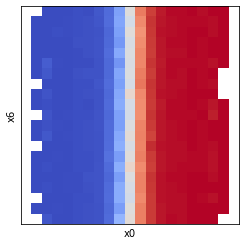

In [21]:
def plot_heatmap(label_map, title, x_name, y_name):
    plt.close()
    # use transpose to rotate the map into the right orientation
    # use [::-1] to invert the new y_axis
    fig, ax = plt.subplots()
    plt.imshow(np.transpose(label_map)[::-1], cmap='coolwarm', interpolation='nearest')
    #plt.axis('off')
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False, # labels along the bottom edge are off
        left = False,
        labelleft= False)     
    plt.xlabel("x{}".format(x_name))
    plt.ylabel("x{}".format(y_name))
    plt.savefig(title)
    plt.show()

plot_heatmap(label_map_given, "{}{}_21_label_map_given.png".format(0,1), 0, 6)

0 1


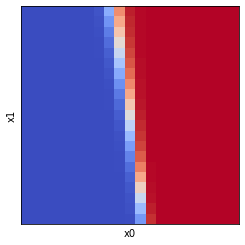

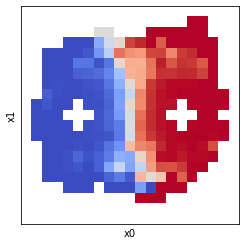

0 2


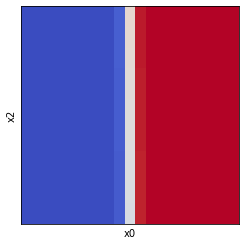

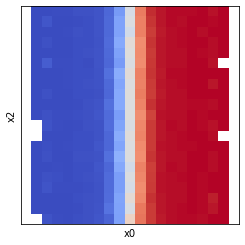

0 3


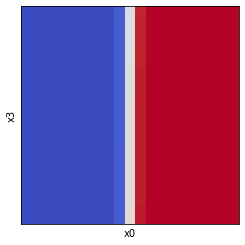

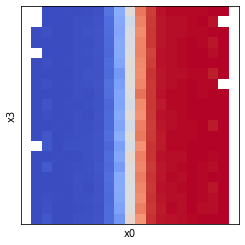

0 4


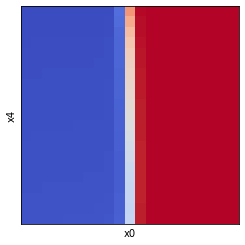

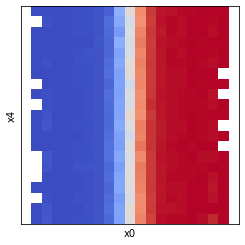

0 5


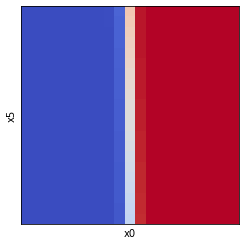

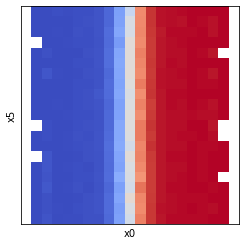

0 6


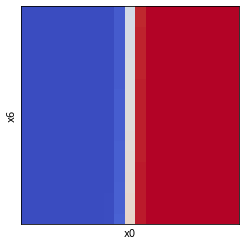

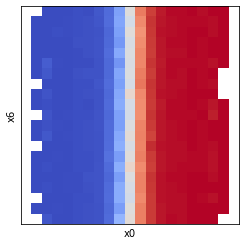

0 7


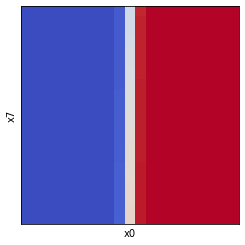

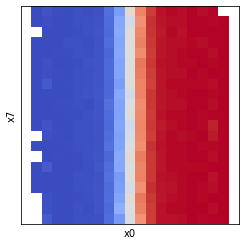

0 8


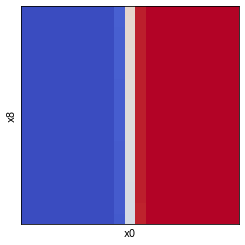

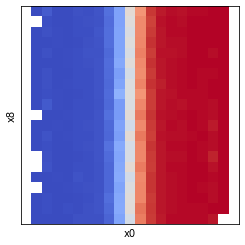

0 9


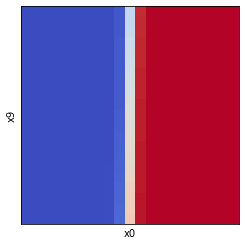

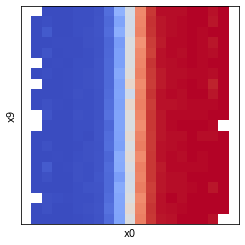

1 2


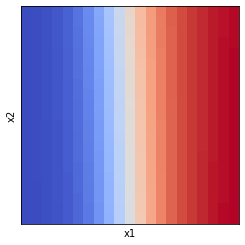

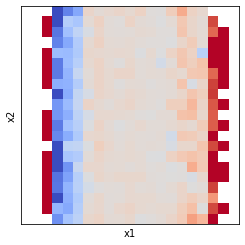

1 3


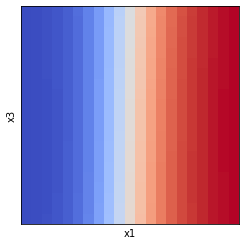

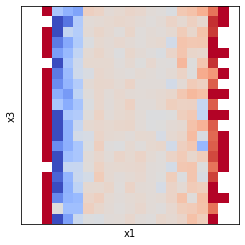

1 4


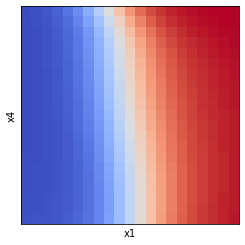

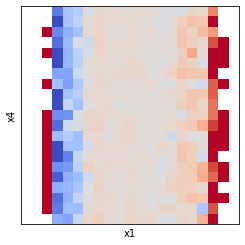

1 5


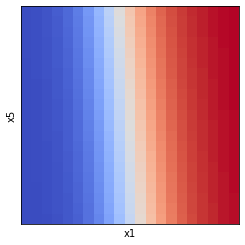

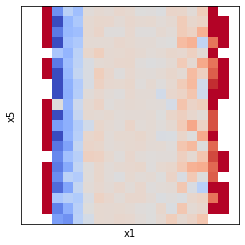

1 6


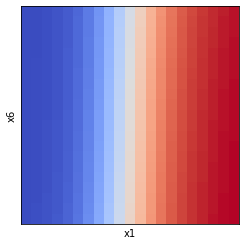

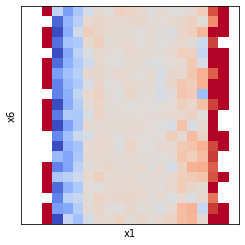

1 7


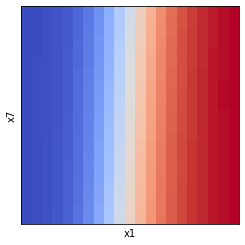

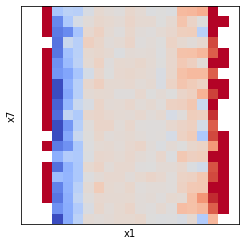

1 8


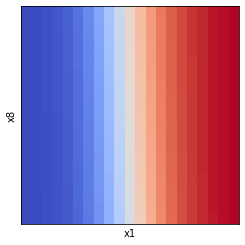

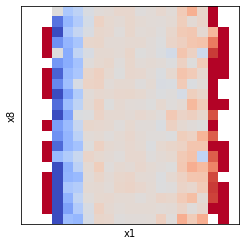

1 9


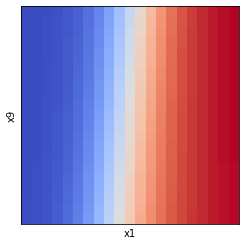

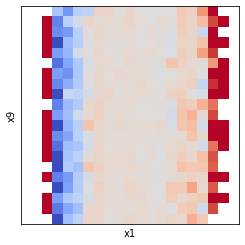

2 3


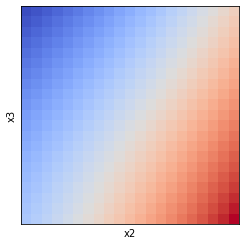

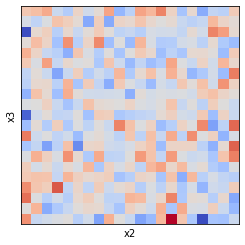

2 4


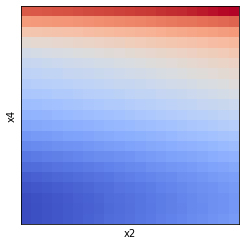

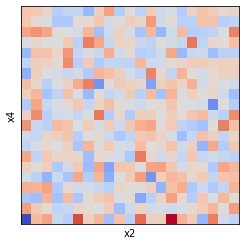

2 5


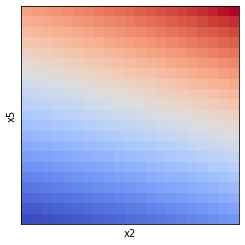

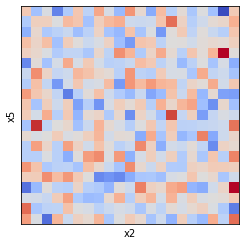

2 6


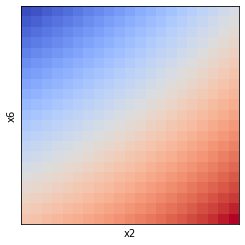

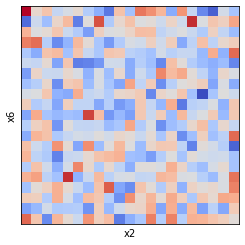

2 7


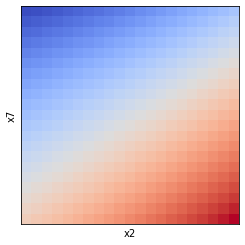

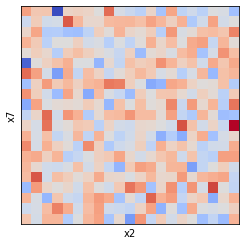

2 8


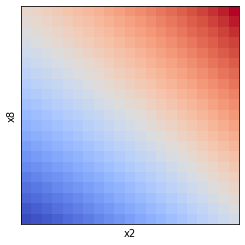

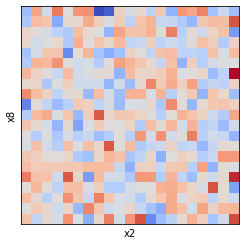

2 9


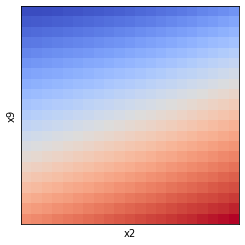

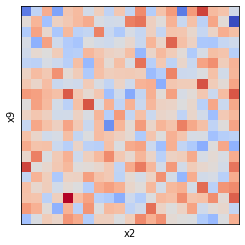

3 4


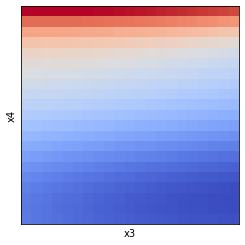

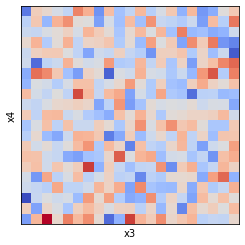

3 5


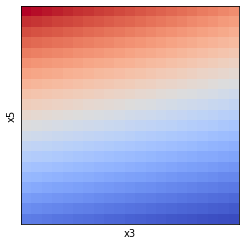

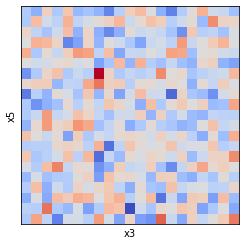

3 6


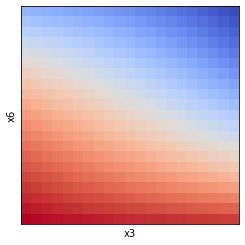

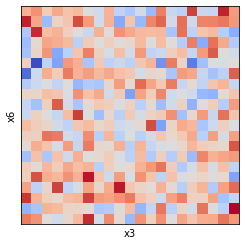

3 7


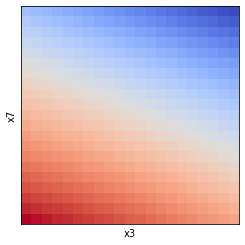

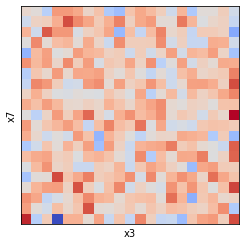

3 8


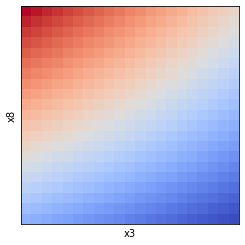

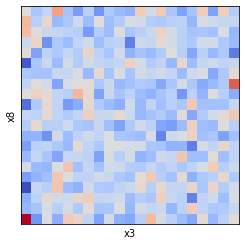

3 9


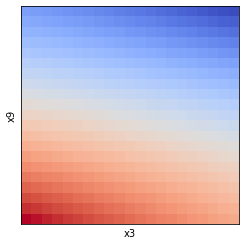

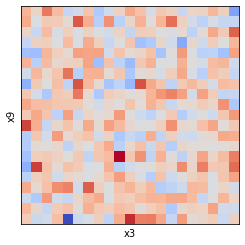

4 5


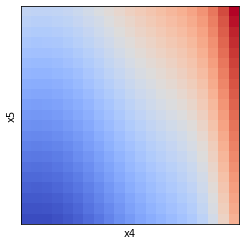

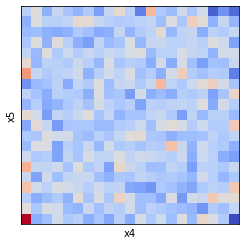

4 6


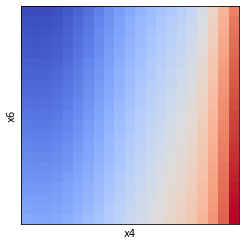

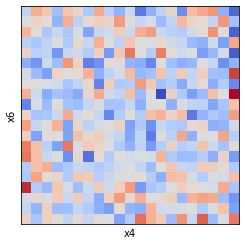

4 7


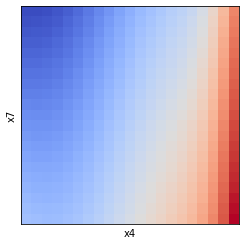

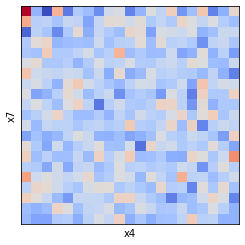

4 8


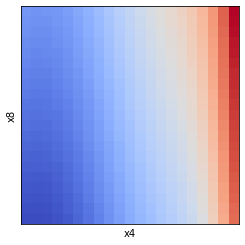

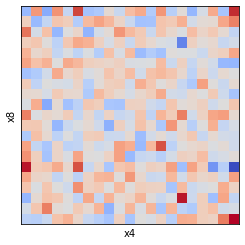

4 9


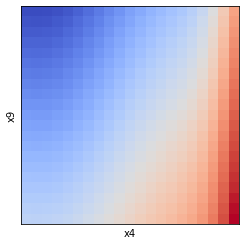

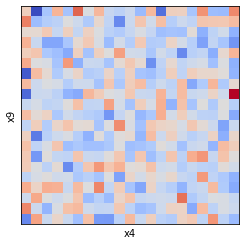

5 6


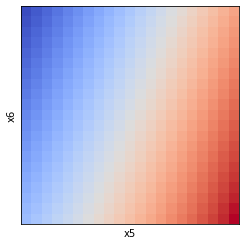

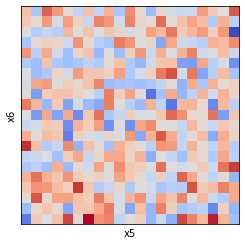

5 7


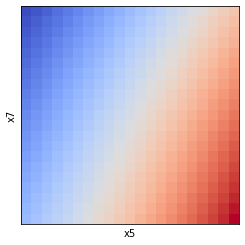

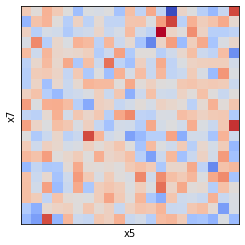

5 8


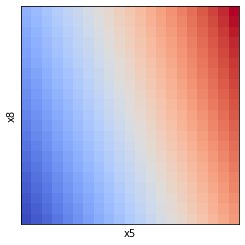

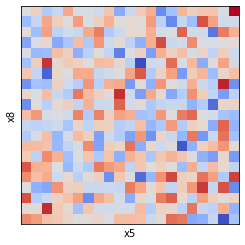

5 9


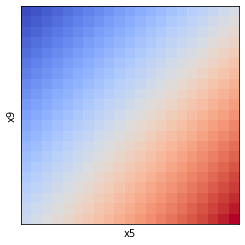

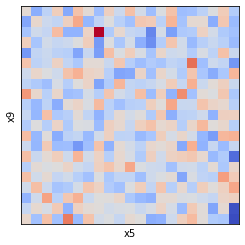

6 7


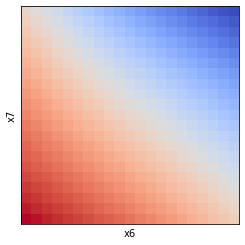

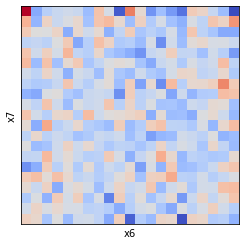

6 8


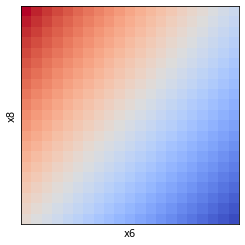

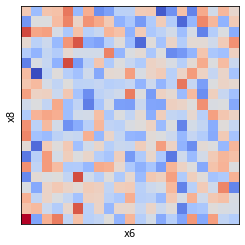

6 9


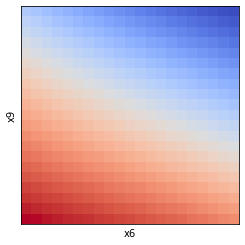

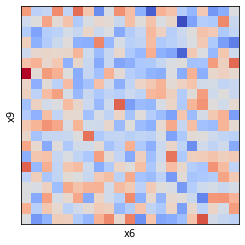

7 8


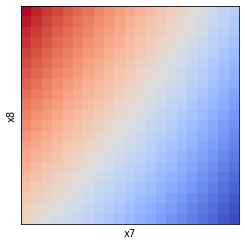

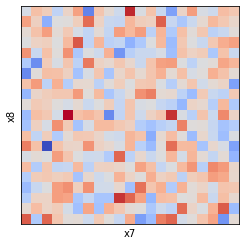

7 9


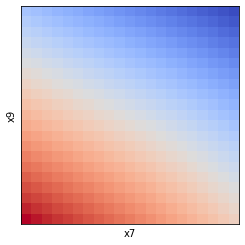

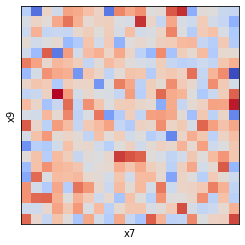

8 9


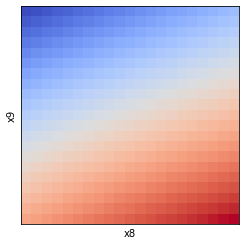

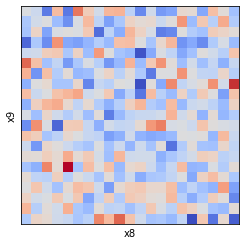

In [22]:
RESOLUTION = 21
for i in range(10):
    for j in range(10):
        if j > i:
            print(i, j)
            label_map_generated = map_generated_labels(model, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1, RESOLUTION), 8, 0, i, j)
            label_map_given = map_given_labels_efficiently(snapshot_list, snapshot_label_list, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1,RESOLUTION), i, j)
            plot_heatmap(label_map_generated, "{}{}_21_label_map_generated.png".format(i,j), i, j)
            plot_heatmap(label_map_given, "{}{}_21_label_map_given.png".format(i,j), i, j)

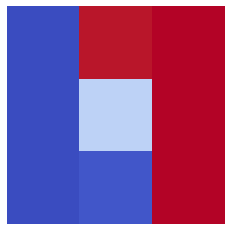

In [185]:
plt.close()
# use transpose to rotate the map into the right orientation
# use [::-1] to invert the new y_axis
plt.imshow(np.transpose(label_map_generated)[::-1], cmap='coolwarm', interpolation='nearest')
plt.axis('off')
plt.savefig("06_21_label_map_generated.png")
plt.show()


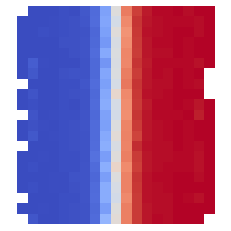

In [180]:
plt.close()
plt.imshow(np.transpose(label_map_given)[::-1], cmap='coolwarm', interpolation='nearest')
plt.axis('off')
plt.savefig("06_21_label_map_given.png")
plt.show()

In [88]:
# modify original numpy arrays, generate new datasets and use that for the comparison 
# --> can only work if random seed is set
def input_perturbation(model, test_ds, snapshot_list, snapshot_label_list, perturbation, check_vars):
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps= 1000)
    loss_list = [[],[],[]]
    for variable_nr in check_vars:
        print("Perturbing variable: {}".format(variable_nr))
        #print(snapshot_list)
        perturbed_snapshot_list = []
        for snapshot in snapshot_list:
            # defines a random perturbation factor according to the currently selected pertubation
            perturb_scaling = 1 + (random.random()-0.5)*2*perturbation
            # uses list comprehension to make a new snapshot where all values are the same except
            # the one for which the variable is to be perturbed. That value is multiplied with the perturbation factor
            perturbed_snapshot_list.append([snapshot[pos_nr] if pos_nr != variable_nr else snapshot[pos_nr]*perturb_scaling for pos_nr in range(len(snapshot))])
        perturbed_snapshot_list = np.array(perturbed_snapshot_list)
        # make a new perturbed Dataset to feed into the previously trained model
        perturbed_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": perturbed_snapshot_list},
                                        {"label":snapshot_label_list, 
                                         "reconstruction":snapshot_list})).shuffle(DATASET_SIZE)
        perturbed_test_ds = perturbed_ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)
        # calculate the different losses with the new dataset
        pert_t_loss, pert_l_loss, pert_r_loss = model.evaluate(perturbed_test_ds, verbose=0, steps = 1000)
        # append the losses to a collective list for later comparison
        loss_list[0].append(max(0,pert_t_loss-orig_t_loss))
        loss_list[1].append(max(0,pert_l_loss-orig_l_loss))
        loss_list[2].append(max(0,pert_r_loss-orig_r_loss))
    print(np.array(loss_list))
    return np.array(loss_list)
loss_list = input_perturbation(model, test_ds, snapshot_list, snapshot_label_list, 0.5, range(10))
#input_perturbation(model, test_ds, snapshot_list, snapshot_label_list, 0.1, range(10))


Perturbing variable: 0
Perturbing variable: 1
Perturbing variable: 2
Perturbing variable: 3
Perturbing variable: 4
Perturbing variable: 5
Perturbing variable: 6
Perturbing variable: 7
Perturbing variable: 8
Perturbing variable: 9
[[0.001 0.001 0.    0.001 0.001 0.    0.    0.001 0.    0.   ]
 [0.001 0.001 0.    0.    0.    0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.003 0.    0.    0.    0.    0.   ]]


In [90]:
for losses in loss_list:
    full_loss = sum(losses)
    for loss in losses:
        print(loss/full_loss)

0.23155400875680654
0.148992468287225
0.04088255780454588
0.1048583864937105
0.1985255598231376
0.0730399728307288
0.019202038653875413
0.18294500734997024
0.0
0.0
0.2574756354954082
0.17642704049406402
0.05844702890728864
0.10251926566972461
0.09823428329093838
0.0827555607124968
0.02372755879389676
0.20041362663618262
0.0
0.0
0.0
0.0
0.0
0.090745434065492
0.909254565934508
0.0
0.0
0.0
0.0
0.0


{'input_snapshots': <tf.Tensor 'args_0:0' shape=(None, 10) dtype=float64>} <class 'dict'>
{'label': <tf.Tensor 'args_1:0' shape=(None,) dtype=float64>, 'reconstruction': <tf.Tensor 'args_2:0' shape=(None, 10) dtype=float64>}
Tensor("TensorArrayV2Read/TensorListGetItem:0", shape=(10,), dtype=float64)
Tensor("TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=float64)
Tensor("TensorArrayV2Read/TensorListGetItem:0", shape=(10,), dtype=float64)
Tensor("TensorArrayV2Read/TensorListGetItem:0", shape=(10, 1), dtype=float32)


In [123]:
took1 = train_s_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_spl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

NameError: name 'train_s_ds' is not defined

In [40]:
# accessing the output of all layers

features_list = [layer.output for layer in model.layers]
print(features_list)
feat_extraction_model = keras.Model(inputs=model.input, outputs=features_list)

img = np.random.random((1,10)).astype('float32')
extracted_features = feat_extraction_model(img)
print(extracted_features)

[<tf.Tensor 'input_snapshots_19:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'dense_11/Identity:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'dense_12/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_13/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_14/Identity:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'dense_15/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_17/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_16/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_18/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'label_1/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'reconstruction_1/Identity:0' shape=(None, 10) dtype=float32>]
[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.578, 0.725, 0.533, 0.842, 0.729, 0.808, 0.3  , 0.716, 0.22 ,
        0.205]], dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.485,  0.301,  0.435,  0.394,  0.249, -0.656,  0.257,

In [130]:
example_batch, label_batch = next(iter(train_sl_ds))    


# with a Sequential model
output = K.function([model.layers[0].input],
                    [model.layers[3].output])
layer_output = output(example_batch)[0]
#print(output)
print(example_batch[0][:2])
print(layer_output[0])
print(label_batch[0])

tf.Tensor([0.673 0.176], shape=(2,), dtype=float64)
[-0.088  0.085]
tf.Tensor(1.0, shape=(), dtype=float64)


200/200 [==============================] - 0s 1ms/step - loss: 0.2169 - mean_squared_error: 0.2169


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()
